In [1]:
import sys
sys.path.insert(0,'/home/nishadgothoskar/jax3dp3/jax3dp3/segmentation/image_background_remove_tool/')
sys.path.insert(0,'/home/nishadgothoskar/jax3dp3/jax3dp3/segmentation/object_segmentation/UnseenObjectClustering/')

import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import jax3dp3.transforms_3d as t3d
import jax3dp3 as j
from dataclasses import dataclass
import sys
import warnings


sys.path.extend(["/home/nishadgothoskar/ptamp/pybullet_planning"])
sys.path.extend(["/home/nishadgothoskar/ptamp"])
warnings.filterwarnings("ignore")

import pybullet_planning
import cv2
import collections
import heapq

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img(
    # '48', '1', "/home/nishadgothoskar/data/bop/ycbv"
    # '52', '1', "/home/nishadgothoskar/data/bop/ycbv"
    '55', '22', bop_ycb_dir
)
intrinsics = j.Intrinsics(
    rgbd.intrinsics.height, rgbd.intrinsics.width,
    rgbd.intrinsics.fx, rgbd.intrinsics.fx,
    rgbd.intrinsics.width/2, rgbd.intrinsics.height/2,
    rgbd.intrinsics.near, rgbd.intrinsics.far
)

In [4]:
top_level_dir = os.path.dirname(os.path.dirname(pybullet_planning.__file__))
mesh_names = ["knife", "spoon", "cracker_box", ]
mesh_paths = [
    os.path.join(top_level_dir,"models/srl/ycb/032_knife/textured.obj"),
    os.path.join(top_level_dir,"models/srl/ycb/031_spoon/textured.obj"),
    os.path.join(top_level_dir,"models/srl/ycb/003_cracker_box/textured.obj"),
]

In [5]:
poses = jnp.array([
    t3d.transform_from_pos(jnp.array([0.0, 0.0, 0.5])),
    t3d.transform_from_pos(jnp.array([0.2, 0.2, 0.5]))
])

In [21]:
poses.shape

(2, 4, 4)

In [16]:
rgbds = j.kubric_interface.render_multiobject_parallel(
    mesh_paths[:2], poses[None,...],
    intrinsics, scaling_factor=1.0, lighting=5.0
)

path:
/home/nishadgothoskar/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/nishadgothoskar/jax3dp3:/home/nishadgothoskar/jax3dp3 --volume /tmp:/tmp   --volume /home/nishadgothoskar/ptamp/models/srl/ycb/032_knife:/home/nishadgothoskar/ptamp/models/srl/ycb/032_knife  --volume /home/nishadgothoskar/ptamp/models/srl/ycb/031_spoon:/home/nishadgothoskar/ptamp/models/srl/ycb/031_spoon  kubricdockerhub/kubruntu /usr/bin/python3 /home/nishadgothoskar/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/nishadgothoskar/ptamp/models/srl/ycb/032_knife/textured.obj'
 '/home/nishadgothoskar/ptamp/models/srl/ycb/031_spoon/textured.obj']
POSES: [[[array([0. , 0. , 0.5], dtype=float32)
   array([1., 0., 0., 0.], dtype=float32)]]

 [[array([0.2, 0.2, 0.5], dtype=float32)
   array([1., 0., 0., 0.], dtype=float32)]]]
CAMERA POSE: [array([0., 0., 0.], dtype=float32)
 array([-4.3713953e-08,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       dtype=

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpzv9aaenb'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpzv9aaenb/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpdv1jggow'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpdv1jggow/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 2, total unfreed memory 0.002518 MB


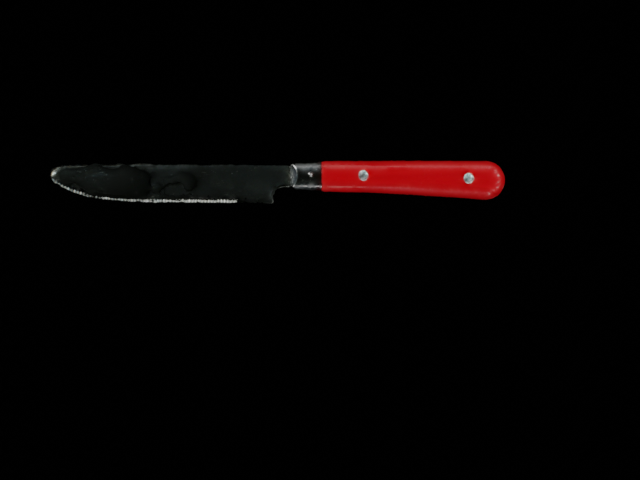

In [20]:
j.get_rgb_image(rgbds[0].rgb)

In [99]:
image = images[0]

In [100]:
depth_scaled =  j.utils.resize(image.depth, intrinsics.height, intrinsics.width)
obs_point_cloud_image = t3d.unproject_depth(depth_scaled, intrinsics)

In [116]:
j.meshcat.show_cloud("1", obs_point_cloud_image.reshape(-1,3))

In [102]:
table_pose, table_dims = j.utils.find_plane_and_dims(
    obs_point_cloud_image[obs_point_cloud_image[:,:,2]<intrinsics.far], 
    ransac_threshold=0.001, inlier_threshold=0.002, segmentation_threshold=0.008
)
table_pose = table_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
if table_pose[:3,2][1] > 0.0:
    table_pose = table_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
    

In [103]:
j.meshcat.show_pose("12", table_pose)

In [104]:
j.meshcat.show_cloud("1",j.t3d.apply_transform(obs_point_cloud_image.reshape(-1,3),
                     j.t3d.inverse_pose(table_pose)
                    ))

In [105]:
import jax3dp3.segment_scene

In [106]:
segmentation_image, mask, viz = jax3dp3.segment_scene.segment_scene(
    image.rgb,
    obs_point_cloud_image,
    intrinsics
)

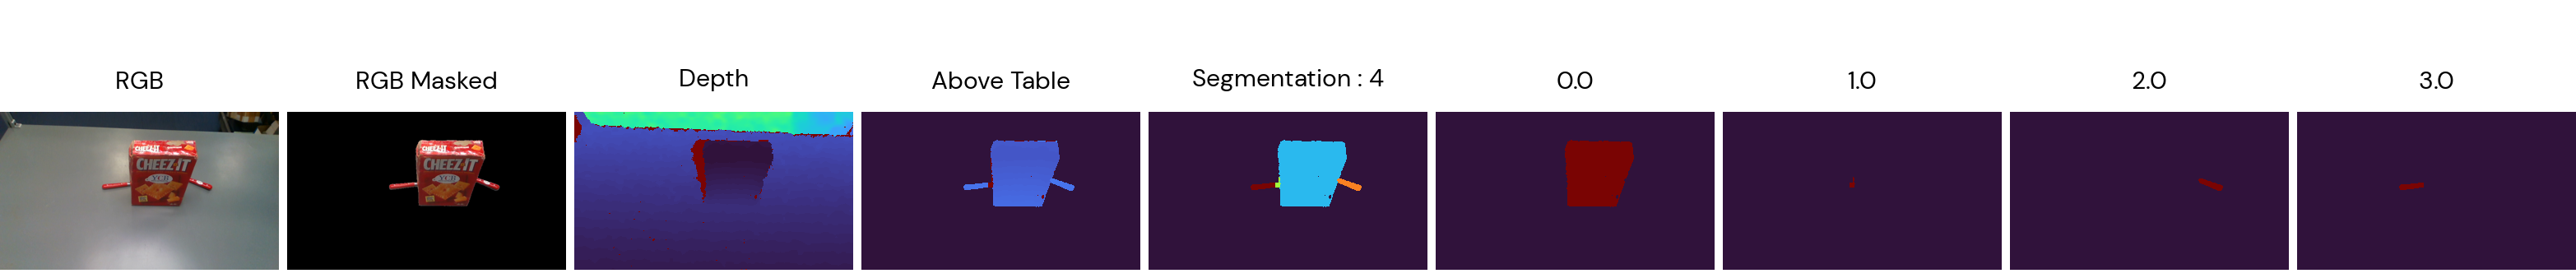

In [107]:
viz

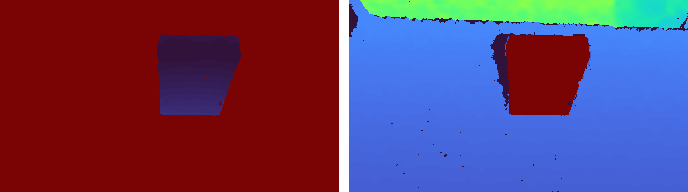

In [118]:
segmentation_id = 0.0
depth_masked, depth_complement = j.get_masked_and_complement_image(depth_scaled, segmentation_image, segmentation_id, intrinsics)

obs_point_cloud_image_masked = t3d.unproject_depth(depth_masked, intrinsics)
obs_point_cloud_image_complement = t3d.unproject_depth(depth_complement, intrinsics)
j.hstack_images(
    [
        j.get_depth_image(depth_masked, max=intrinsics.far),
        j.get_depth_image(depth_complement, max=intrinsics.far)
    ]
)

In [124]:
masked_cloud = obs_point_cloud_image_masked[obs_point_cloud_image_masked[...,2] < renderer.intrinsics.far,:]
points_in_table_ref_frame =  t3d.apply_transform(
    masked_cloud,
    t3d.inverse_pose(table_pose)
)

In [125]:
j.meshcat.show_cloud("3", masked_cloud, color=j.RED)

In [126]:
center_x, center_y, _ = ( points_in_table_ref_frame.min(0) + points_in_table_ref_frame.max(0))/2
contact_init = jnp.array([center_x, center_y, 0.0])
print(contact_init)

[-0.03707377  0.06681715  0.        ]


In [127]:
jnp.tile(contact_init, (10,1))

Array([[-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ],
       [-0.03707377,  0.06681715,  0.        ]], dtype=float32)

In [123]:
obj_idx = 0
pose_proposals = jax3dp3.scene_graph.pose_from_contact_and_face_params_parallel_jit(
    contact_param_sweep,
    face_param_sweep,
    renderer.model_box_dims[obj_idx],
    table_pose
)

NameError: name 'contact_param_sweep' is not defined

In [ ]:

masked_cloud = obs_point_cloud_image_masked.reshape(-1, 3)
masked_cloud = masked_cloud[masked_cloud[:,2] < renderer.intrinsics.far,:]

points_in_table_ref_frame =  t3d.apply_transform(
    masked_cloud,
    t3d.inverse_pose(contact_plane_pose_in_cam_frame)
)

point_seg = j.utils.segment_point_cloud(points_in_table_ref_frame, 0.1)

points_filtered = points_in_table_ref_frame[point_seg == j.utils.get_largest_cluster_id_from_segmentation(point_seg)]

center_x, center_y, _ = ( points_filtered.min(0) + points_filtered.max(0))/2

In [34]:
R_SWEEP = jnp.array([0.005])
OUTLIER_PROB=0.1
OUTLIER_VOLUME=1.0

In [128]:
C2F_SCHED = j.c2f.make_schedules(
    grid_widths=[0.05, 0.03, 0.02, 0.02],
    angle_widths=[jnp.pi, jnp.pi, 0.001, jnp.pi],
    grid_params=[(11,11,31),(11,11,31),(11,11,31),(11,11,31)],
)

In [129]:
hypotheses_over_time = j.c2f.c2f_contact_parameters(
    renderer,
    obs_point_cloud_image,
    obs_point_cloud_image_masked,
    obs_point_cloud_image_complement,
    C2F_SCHED,
    t3d.inverse_pose(image.camera_pose) @  table_plane,
    R_SWEEP,
    OUTLIER_PROB,
    OUTLIER_VOLUME,
    renderer.model_box_dims,
    num_batches=5
)

5 batches with batchsize 4501
batch split complete
proposals complete


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.37 GiB (GPU 0; 39.41 GiB total capacity; 404.19 MiB already allocated; 2.65 GiB free; 432.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
hypotheses_over_time[-1]

[(Array(115833.96, dtype=float32),
  Array(0, dtype=int32),
  Array([-0.15209033,  0.16561997, -2.7236466 ], dtype=float32),
  Array([[-0.86040866, -0.01181026, -0.5099566 ,  0.16184375],
         [-0.42702684,  0.56347656,  0.70754087, -0.07590026],
         [ 0.27908242,  0.8261719 , -0.49003538,  0.70965505],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)),
 (Array(115817.13, dtype=float32),
  Array(1, dtype=int32),
  Array([-0.16009033,  0.18561995, -2.0944614 ], dtype=float32),
  Array([[-0.39544302,  0.9186697 , -0.01181023,  0.18265502],
         [-0.7616544 , -0.32066873,  0.5634765 , -0.08044583],
         [ 0.51403564,  0.23190418,  0.8261719 ,  0.7128318 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)),
 (Array(115683.68, dtype=float32),
  Array(2, dtype=int32),
  Array([-0.15609033,  0.11161996,  1.884423  ], dtype=float32),
  Array([[ 0.01181025, -0.90863824, -0.4175433 ,  0.10896999],
         [-0

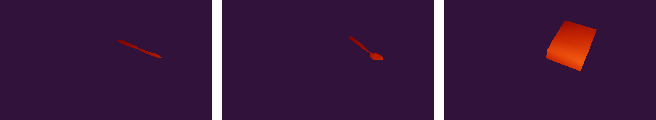

In [32]:
reconstruction_images = []
for hypothesis in hypotheses_over_time[-1]:
    _,idx,_,pose = hypothesis
    reconstruction_images.append(j.get_depth_image(renderer.render_single_object(pose, idx)[:,:,2]))
j.hstack_images(reconstruction_images)

In [25]:
scores = jnp.array([i[0] for i in hypotheses_over_time[-1]])
j.utils.normalize_log_scores(scores)

Array([1.0000000e+00, 4.7279574e-08, 0.0000000e+00], dtype=float32)

In [4]:
mesh = j.mesh.load_mesh(mesh_path)
mesh

<trimesh.Trimesh(vertices.shape=(34934, 3), faces.shape=(65536, 3))>

In [26]:
obs_point_cloud_image.shape

(120, 212, 3)

In [ ]:
camera_pose

In [5]:
intrinsics = j.Intrinsics(
    1000,1000,100.0,100.0,500.0,500.0,
    0.001, 1.0
)
object_pose = jnp.linalg.inv(camera_pose)

NameError: name 'camera_pose' is not defined

In [87]:
all_data = j.kubric_interface.render_multiobject_parallel([mesh_path], object_pose[None,None,...],
                                                          intrinsics, scaling_factor=1.0, lighting=2.0) # multi img singleobj

rgbd = all_data[0]

path:
/home/nishadgothoskar/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/nishadgothoskar/jax3dp3:/home/nishadgothoskar/jax3dp3 --volume /tmp:/tmp   --volume /home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/032_knife:/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/032_knife  kubricdockerhub/kubruntu /usr/bin/python3 /home/nishadgothoskar/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/nishadgothoskar/jax3dp3/assets/ycb_video_models/models/032_knife/textured.obj']
POSES: [[[array([-0. , -0. ,  0.5], dtype=float32)
   array([ 0.        , -0.        , -0.70710677,  0.70710677], dtype=float32)]]]
CAMERA POSE: [array([0., 0., 0.], dtype=float32)
 array([-4.3713953e-08,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       dtype=float32)                                                   ]


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpxe5l06dq'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpxe5l06dq/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 1, total unfreed memory 0.001259 MB


In [88]:
rgbd.segmentation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

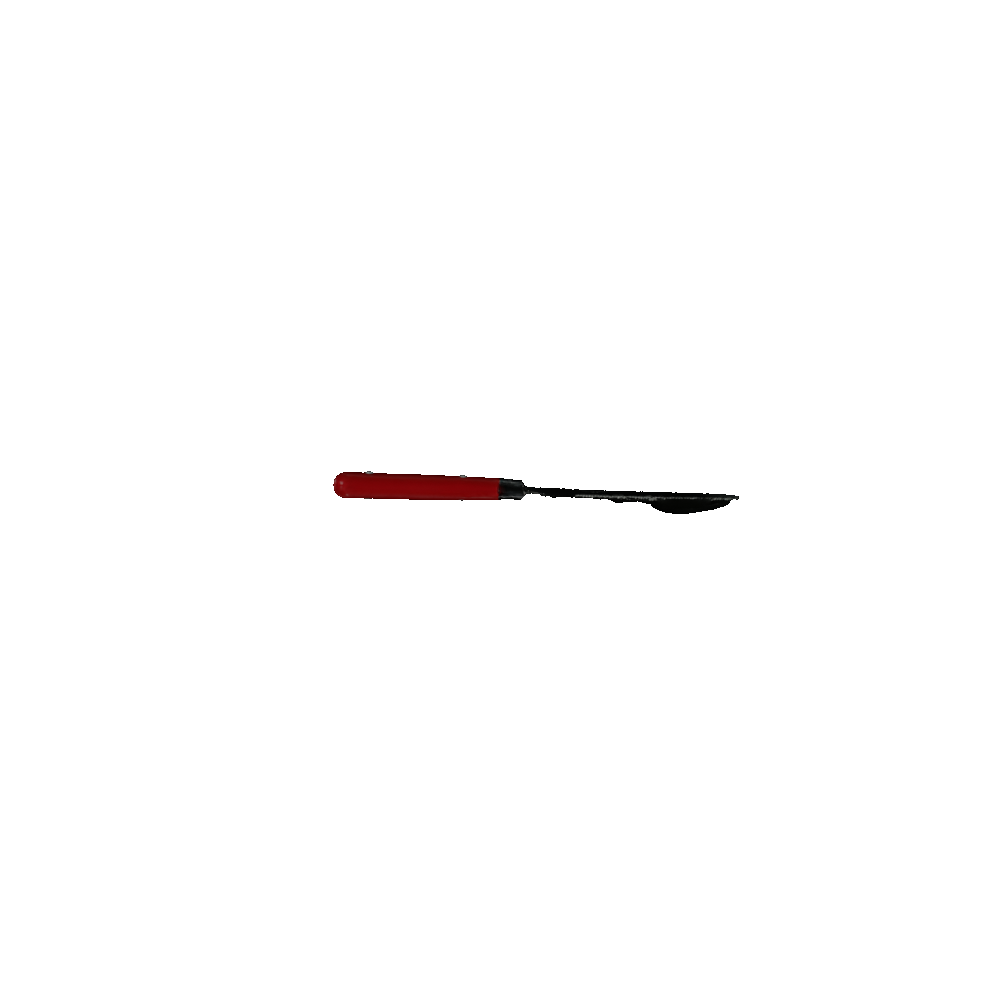

In [83]:
rgb = np.array(rgbd.rgb)
rgb[rgbd.segmentation == 0,:] = 255.0
j.get_rgb_image(rgb)